<img src='../img/joint_school_banner_2.png' alt='Training school and workshop on dust' align='center' width='100%'></img>

<br>

<hr>

# Sentinel-3 OLCI Composites

### About
Sentinel-3 OLCI Level-1 data products are available as Full (`OL_1_EFR`) and Reduced Resolution (`OL_1_ERR`) data files. The following notebook shows you how `OL_1_EFR` data are structured and how you can generate true- and false-colour composite images.

Find more information on the OLCI data products in the <a href='https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-olci' target='_blank'>Sentinel-3 OLCI User Guide</a>.

This notebook provides an introduction to the Sentinel-3 OLCI data and enables you to generate true- and false-colour composite images of the fires in southern Italy and in Greece that occured in August 2021.

### Basic Facts

> **Spatial resolution**: `300m` <br>
> **Spatial coverage**: `Global` <br>
> **Revisit time**:  `Less than 2 days` <br>
> **Data availability**: `since 2016`


### How to access the data

Sentinel-3 OLCI data can be downloaded via the <a href='https://scihub.copernicus.eu/dhus/#/home' target='_blank'>Copernicus Open Access Hub</a>. You need to register for an account before downloading data. 

Sentinel-3 OLCI data products are disseminated as `.zip archives`, containing data files in `NetCDF` format.


<hr>

##### Load required libraries

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from skimage import exposure

import glob

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

##### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='s3_load_browse'></a>1. Load and browse Sentinel-3 OLCI Level-1 data

Sentinel-3 Level-1 data are dissiminated as `.zip archives` when downloaded.

[OPTIONAL] The first step is to unzip file from the zipped archive downloaded. This is optional as we have already unzipped the file for you. This is why the code is commented out.

In [3]:
# import zipfile
# with zipfile.ZipFile('../../../eodata/lps_fire/sentinel-3/olci/2021/08/07/S3B_OL_1_EFR____20210807T085200_20210807T085500_20210808T130135_0179_055_278_2340_LN1_O_NT_002.zip', 'r') as zip_ref:
#    zip_ref.extractall('../../../eodata/lps_fire/sentinel-3/olci/2021/08/07/')

The unzipped folder contains 30 data files in `NetCDF` format. Data for each channel is stored in a single `NetCDF` file. Additionally, you get information on `qualityFlags`, `time_coordinates` or `geo_coordinates`.

You can see the names of the 30 data files by looping through the data directory. You see that the channel information follow the same naming and all end with `_radiance.nc`.

In [4]:
olci_dir = '../../../eodata/lps_fire/sentinel-3/olci/2021/08/07/S3B_OL_1_EFR____20210807T085200_20210807T085500_20210808T130135_0179_055_278_2340_LN1_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[11])

time_coordinates.nc
Oa01_radiance.nc
Oa02_radiance.nc
Oa03_radiance.nc
Oa04_radiance.nc
Oa05_radiance.nc
Oa06_radiance.nc
Oa07_radiance.nc
Oa08_radiance.nc
Oa09_radiance.nc
Oa10_radiance.nc
Oa11_radiance.nc
Oa12_radiance.nc
Oa13_radiance.nc
Oa14_radiance.nc
Oa15_radiance.nc
Oa16_radiance.nc
Oa17_radiance.nc
Oa18_radiance.nc
Oa19_radiance.nc
Oa20_radiance.nc
Oa21_radiance.nc
qualityFlags.nc
instrument_data.nc
removed_pixels.nc
geo_coordinates.nc
tie_geo_coordinates.nc
tie_meteo.nc
tie_geometries.nc


### Load OLCI channel information

#### Load one single channel

As a first step, you can load one channel with xarray's function `open_dataset`. This will help you to understand how the data is structured.
You see that the data of each channel is a two dimensional data array, with `rows` and `columns` as dimensions. 

In [5]:
olci_xr = xr.open_dataset(olci_dir+'Oa01_radiance.nc')
olci_xr

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    Oa01_radiance  (rows, columns) float32 ...
Attributes: (12/16)
    absolute_orbit_number:  17105
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-08T13:01:35Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-07T08:52:00.193254Z
    stop_time:              2021-08-07T08:55:00.160958Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Load all channel information into one xarray object

The next step is to bring the individual data files together into one `xarray` data object. You can do this with xarray's function `open_mfdataset`. Since all channel files have the same data structure, you can combine all channels by coordinates using the keyword argument `by_coords`. The result is a `xarray` object with 21 data variables. Each channel is represented as a data variable.

In [6]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/21)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    ...             ...
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
Attributes: (12/16)
    absolute_orbit_number:  17105
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-08T13:01:35Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-07T08:52:00.193254Z
    stop_time:              2021-08-07T08:55:00.160958Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

#### Example to plot one channel

First, you can initialize a figure with matplotlib's function `.figure`, specifying the figure size. To get an impression of the image, you can simply plot one channel of the xarray object with xarray's function  `.plot.imshow()`. Let's plot channel 8 `Oa08_radiance`. The example shows that you can easily visualize the image itself, but without geographic information.

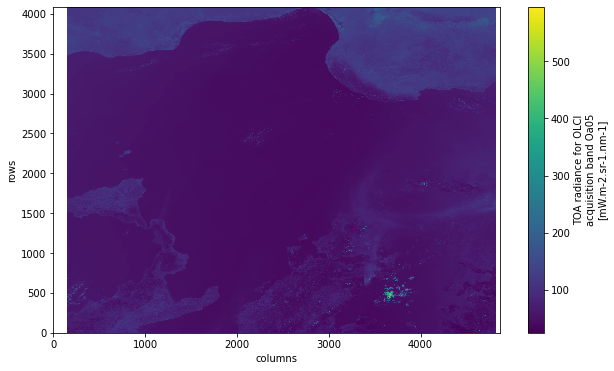

In [7]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa05_radiance'].plot.imshow()

### Load OLCI geographic coordinates

If you want to georeference your image, you have to load the geographic coordinates file. You can load it as xarray with `open_dataset`. The file is called `geo_coordinates.nc`. You see that the file contains three variables: `latitude`, `longitude` and `altitude`.

Let's store the latitude and longitude data as `lat` and `lon` variables respectively.

In [8]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
olci_geo_coords

<xarray.Dataset>
Dimensions:    (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes: (12/16)
    absolute_orbit_number:  17105
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2021-08-08T13:01:35Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.11
    start_time:             2021-08-07T08:52:00.193254Z
    stop_time:              2021-08-07T08:55:00.160958Z
    title:                  OLCI Level 1b Product, Geo Coordinates Data Set

In [9]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

### Select OLCI channels for a true colour composite

Depending on the combination of different OLCI channels, your composite might highlight specific phenomena. The channel combination for a true colour image could be:
- Red: `Oa08_radiance`
- Green: `Oa06_radiance`
- Blue: `Oa04_radiance`

Let's define a function called [select_channels_for_rgb](./ltpy_functions.ipynb#rgb_channels), which makes the channel selection more flexible. The function returns the three bands individually.

In [10]:
def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    """ 
    Selects the channels / bands of a multi-dimensional xarray for red, green and blue composites.
    
    Parameters:
        xarray(xarray Dataset): xarray Dataset object that stores the different channels / bands.
        red_channel(str): Name of red channel to be selected
        green_channel(str): Name of green channel to be selected
        blue_channel(str): Name of blue channel to be selected

    Returns:
        Three xarray DataArray objects with selected channels / bands
    """  
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]

In [11]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
red

<xarray.DataArray 'Oa08_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-dd14352787f9c10e8ac169653491268aOa08_radiance, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4865), chunktype=numpy.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa08_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa08
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

### Advanced image processing - Normalization and histogram equalization

#### Normalization

A common operation in image processing is the normalization of data values. Normalization changes the range of pixel intensity and can improve the constrast.
Let's define a function called [normalize](./ltpy_functions.ipynb#normalize), which normalizes a numpy array into a scale between 0.0 and 1.0.

In [12]:
def normalize(array):
    """ 
    Normalizes a numpy array / xarray DataArray object value to values between 0 and 1.
    
    Parameters:
        xarray(numpy array or xarray DataArray): xarray DataArray or numpy array object.

    Returns:
        Normalized array
    """ 
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

You can now apply the function [normalize](./ltpy_functions.ipynb#normalize) to each RGB channel. At the end, you can bring the three channels together into one `rgb` array with `numpy.dstack`. By verifying the shape of the resulting array, you see that the `rgb` array has now three dimensions.

In [13]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [14]:
rgb = np.dstack((redn, greenn, bluen))
rgb.shape

(4091, 4865, 3)

You can now plot the `rgb` image to see if maybe further image processing methods could be applied. If you visualize the image with `plt.imshow()`, you see that the constrast is not very strong. A further step is to sharpen the contrast with the help of a **Histogram equalization**.

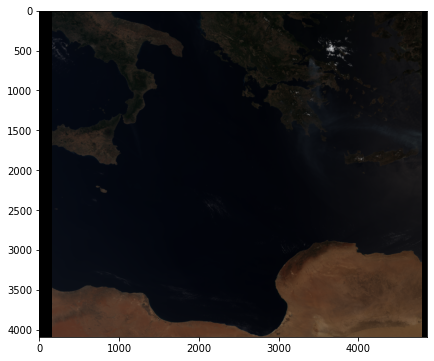

In [15]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

#### Histogram equalization

Histogram equalization is a method in image processing that adjusts the contrast using the image's histogram. Python's `skikit-learn` library has useful tools to make a histogram equalization quite straighforward. The `skimage` library provides a function `exposure.equalize_adapthist()` which can be applied to the rgb data array.

In [16]:
rgb = exposure.equalize_adapthist(rgb)

You can again plot the `rgb` image with `plt.imshow()`. You can see that the histogram equalization improved the contrast of the image.

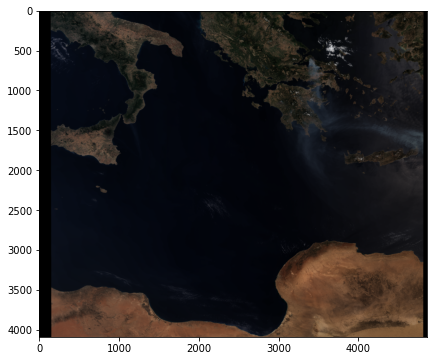

In [17]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

## <a id='s3_true_color'></a>2. Visualise a georeferenced true colour composite

The final step is to georeference the true colour composite image. Therefore, you need the extracted `lat` and `lon` information extracted above.

Let's plot the image with matplotlib's `pcolormesh` function. To be able to visualize the array as RGB, you have to map first the `rgb` array to a colour array.

In [18]:
mesh_rgb = rgb[:, :, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

The last step is to visualize the colour array and add additional information, e.g. gridlines and coastlines. As you want to reuse the plotting code again, you can define a function called [visualize_s3_pcolormesh](./ltpy_functions.ipynb#visualize_s3_pcolormesh).

In [19]:
def visualize_s3_pcolormesh(color_array, array, latitude, longitude, title):
    """ 
    Visualizes a numpy array (Sentinel-3 data) with matplotlib's 'pcolormesh' function as composite.
    
    Parameters:
        color_array (numpy MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        longitude (numpy Array): array with longitude values
        latitude (numpy Array) : array with latitude values
        title (str): title of the resulting plot
    """
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=ccrs.Mercator())
    ax.coastlines()
    ax.set_extent([15, 25, 35, 40]) # Mediterranean

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}
    
    img1 = plt.pcolormesh(longitude, latitude, array*np.nan, color=colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree()
                          )
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.show()

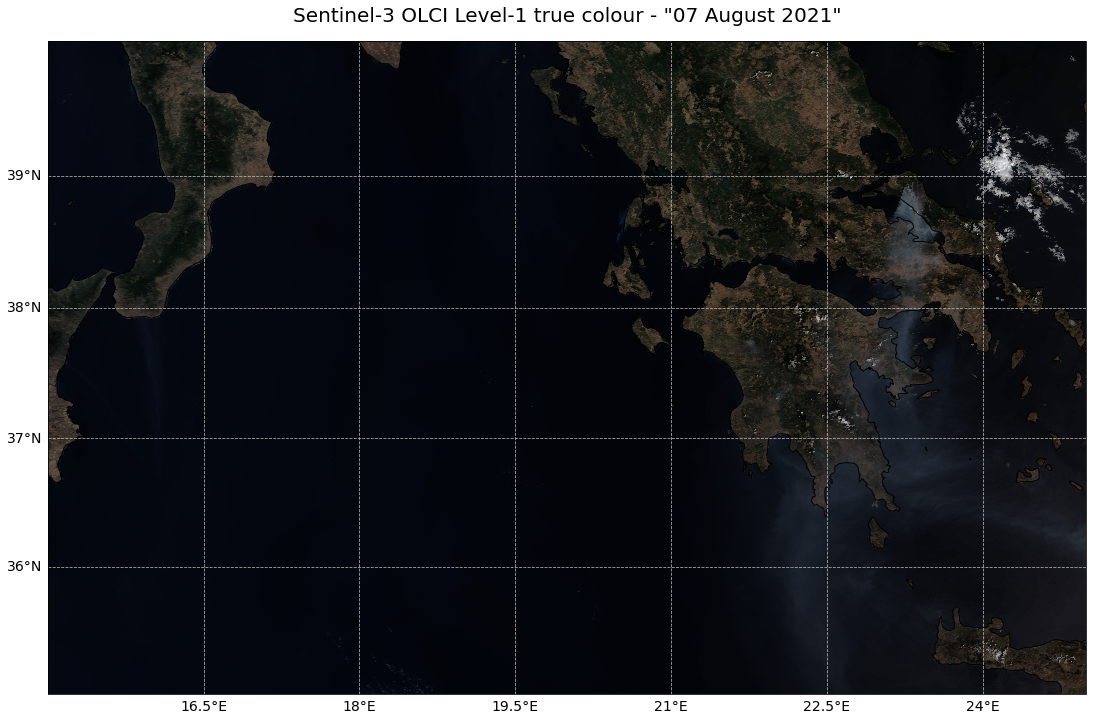

In [20]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 true colour - "07 August 2021"')

<br>

## <a id='s3_false_color'></a>3. Create a false colour composite and plot it as georeferenced image 

A false colour image can be applied if specific phenomena should be highlighted. A channel combination for Sentinel-3 OLCI data could be:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

This selection is advantageous to identify burnt areas and wildfires. The combination highlights healthy vegetation as red and burnt areas as black.

Let's repeat the steps from above to visualize the image as False colour composite.

#### Select RGB channels

The first step is to select the channels `Oa17_radiance`, `Oa05_radiance` and `Oa02_radiance` as red, green and blue channels respectively.

In [21]:
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')

#### Normalize

You also want to normalize these channels and stack them afterwards into a three-dimensional array.

In [22]:
redn_fc = normalize(red_fc)
greenn_fc = normalize(green_fc)
bluen_fc = normalize(blue_fc)

In [23]:
rgb_fc = np.dstack((redn_fc, greenn_fc, bluen_fc))

#### Histogram equalization

Apply histogram equalization.

In [24]:
rgb_fc = exposure.equalize_adapthist(rgb_fc)

Let's have a sneak peek at the un-georeferenced image with `plt.imshow()`

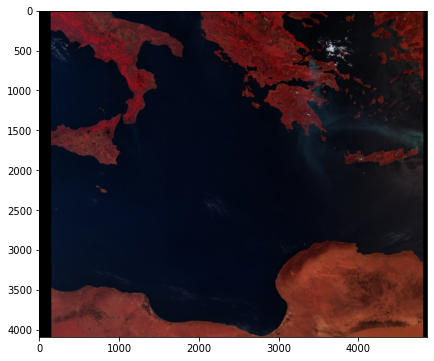

In [26]:
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_fc)

#### Visualize with function `visualize_s3_pcolormesh`

In [27]:
mesh_rgb = rgb_fc[:, :, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

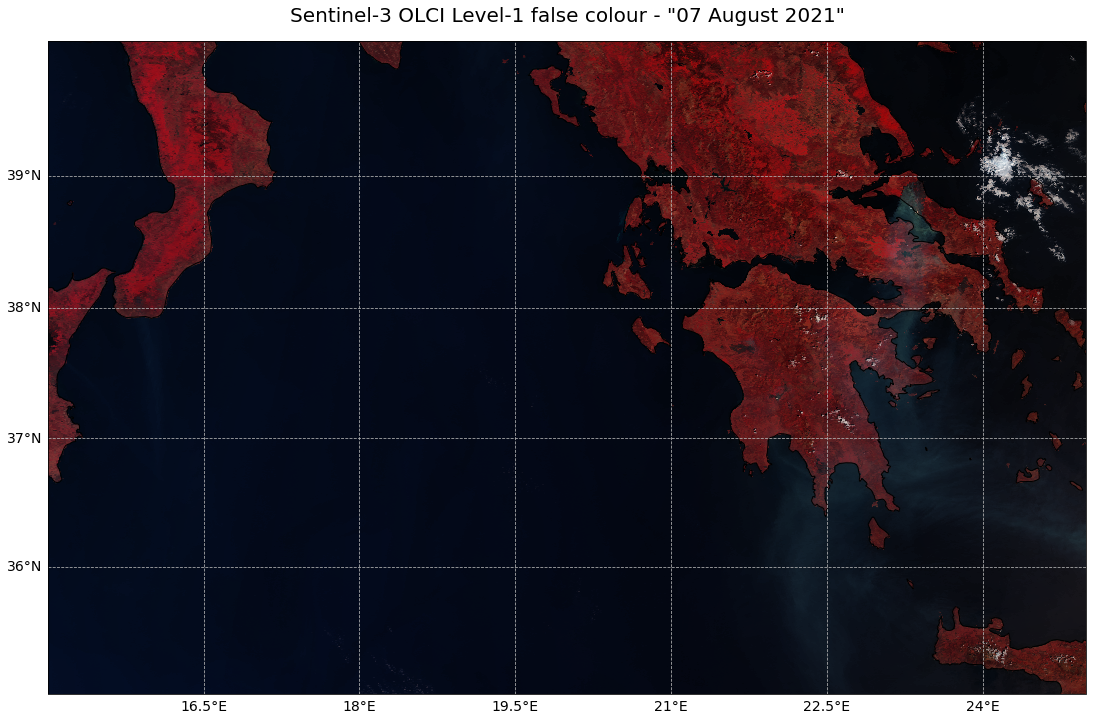

In [28]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon,
                        title='Sentinel-3 OLCI Level-1 false colour - "07 August 2021"',
                       )

**Return to the chapter:**
- [Atmospheric impacts of wildfires](./01_atmosphere_intro.ipynb#s3_olci)

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.